In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

pd_train = pd.read_csv('/content/drive/MyDrive/plant-pathology-2020-fgvc7/train.csv')
pd_test  = pd.read_csv('/content/drive/MyDrive/plant-pathology-2020-fgvc7/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/plant-pathology-2020-fgvc7/sample_submission.csv')

## EDA


In [3]:
pd_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
healthy = pd_train.loc[pd_train['healthy']==1]
multiple_diseases = pd_train.loc[pd_train['multiple_diseases']==1]
rust = pd_train.loc[pd_train['rust']==1]
scab = pd_train.loc[pd_train['scab']==1]

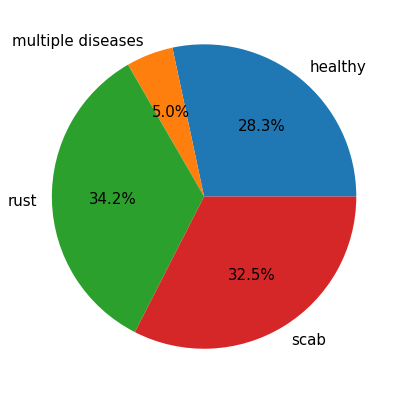

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['healthy', 'multiple diseases', 'rust', 'scab'] # Target Value Value
# Target value distribution pie chart
plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)], 
        labels=label, 
        autopct='%1.1f%%');

In [6]:
# import cv2
# import numpy as np
# # Load training images
# img_size =100
# train_image = []
# for name in pd_train['image_id']:
#     img   = cv2.imread('/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/' + name + '.jpg')
#     image = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
#     train_image.append(image)

# # Display some training images
# fig, ax = plt.subplots(1, 4, figsize = (15, 15))
# for i in range(4):
#     ax[i].set_axis_off()
#     ax[i].imshow(train_image[i])

In [7]:
# # Load test images
# test_image = []
# for name in pd_test['image_id']:
#     img   = cv2.imread('/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/' + name + '.jpg')
#     image = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
#     test_image.append(image)

# # Display some test images
# fig, ax = plt.subplots(1, 4, figsize = (15, 15))
# for i in range(4):
#     ax[i].set_axis_off()
#     ax[i].imshow(test_image[i])  

## Data Processing


In [8]:
import torch # Pytorch
import random
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
from sklearn.model_selection import train_test_split

# Split train data and valid data
_, valid = train_test_split(pd_train, 
                            test_size=0.1,
                            stratify=pd_train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                            random_state=10)

## packages


In [10]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                1.1.0
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.5.0
bs4                           0.0

In [11]:
!pip uninstall opencv-python-headless==4.5.5.64


Found existing installation: opencv-python-headless 4.5.2.52
Uninstalling opencv-python-headless-4.5.2.52:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.2.52.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-8daa01ff.so.58.109.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-06a336f2.so.58.61.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-01d48d95.so.56.60.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-098682aa.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libpng15-c2ffaf3d.so.15.13.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libssl-f3db6a3b.so.1.1
    /usr/local/lib/python3.7/dist-package

In [12]:
pip install opencv-python-headless==4.5.2.52


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_python_headless-4.5.2.52-cp37-cp37m-manylinux2014_x86_64.whl (38.2 MB)


In [13]:

!pip install -U albumentations



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## data

In [15]:
import cv2
from torch.utils.data import Dataset # Class for data generation
import numpy as np

class ImageDataset(Dataset):
    # Initialization method
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # Call the __init__() method of the inherited Dataset class
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    # Dataset size return method
    def __len__(self):
        return len(self.df)
    
    # Data return method corresponding to index(idx)
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0] # Image ID
        img_path = self.img_dir + img_id + '.jpg' # Image file path
        image = cv2.imread(img_path) # Reda Image file
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert Image color
        # Transform Image
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # If test data, return image data only; otherwise, return target values(label) as well.
        if self.is_test:
            return image
        else:
            # Index of the largest of the four target values
            label = np.argmax(self.df.iloc[idx, 1:5]) 
            return image, label

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [17]:
img_dir = '/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/'

dataset_train = ImageDataset(pd_train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [18]:
from torch.utils.data import DataLoader # Class for creating data loaders

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False)

## Model

In [19]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from efficientnet_pytorch import EfficientNet # EfficientNet Model

# Load pre-trained efficientnet-b7 model
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) 

model = model.to(device) # Assign device

Loaded pretrained weights for efficientnet-b7


In [21]:
import torch.nn as nn # Neural Network module

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00007, weight_decay=0.0001)
import transformers
from transformers import get_cosine_schedule_with_warmup

epochs = 10 # Number of total epochs

# Scheduler
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*5, 
                                            num_training_steps=len(loader_train)*epochs)

In [22]:
from sklearn.metrics import roc_auc_score # ROC AUC Score Calculation Function
from tqdm.notebook import tqdm # Progress Bar

# Training as much as epochs.
for epoch in range(epochs):
    model.train() # Set Model to Training State
    epoch_train_loss = 0 # Initialize loss values by epoch (for train data)
    # Repeat 'Repeatation Counts' to extract data by mini-batch size
    for images, labels in tqdm(loader_train):
        # Assign image, label (target value) data mini-position to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Grad Initialization in optimizer
        optimizer.zero_grad()
        # Calculate output values using image data as input values for neural network models
        outputs = model(images)
        # Use the loss function to calculate loss of outputs and labels
        loss = criterion(outputs, labels)
        loss.backward() # Perform Backpropagation
        optimizer.step() # Update Weight
        scheduler.step() # Update Scheduler Learning Rate
        epoch_train_loss += loss.item() # Add loss in current deployment (for training data)
    # Print Training data loss
    print(f'Epoch [{epoch+1}/{epochs}] - Train data loss : {epoch_train_loss/len(loader_train):.4f}')
    
    model.eval() # Set Model to Evaluation State
    epoch_valid_loss = 0 # Initialize loss values by epoch (for valid data)
    preds_list = [] 
    true_onehot_list = [] 
    
    with torch.no_grad(): # Inactivate grad calculation
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # Predicted Probability Value
            true_onehot = torch.eye(4)[labels].cpu().numpy() # True value (in one-hot encoding format)
            # Store predicted probability values and tr ue values
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
        # Print validation data loss values and ROC AUC scores
        print(f'Epochs [{epoch+1}/{epochs}] - Valid data loss : {epoch_valid_loss/len(loader_valid):.4f} / Valid data ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [1/10] - Train data loss : 1.3106
Epochs [1/10] - Valid data loss : 0.9040 / Valid data ROC AUC : 0.8635


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [2/10] - Train data loss : 0.6493
Epochs [2/10] - Valid data loss : 0.2292 / Valid data ROC AUC : 0.9412


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [3/10] - Train data loss : 0.4217
Epochs [3/10] - Valid data loss : 0.1487 / Valid data ROC AUC : 0.9942


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [4/10] - Train data loss : 0.3058
Epochs [4/10] - Valid data loss : 0.1046 / Valid data ROC AUC : 0.9926


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [5/10] - Train data loss : 0.2548
Epochs [5/10] - Valid data loss : 0.0722 / Valid data ROC AUC : 0.9969


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [6/10] - Train data loss : 0.1793
Epochs [6/10] - Valid data loss : 0.0387 / Valid data ROC AUC : 0.9996


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [7/10] - Train data loss : 0.1243
Epochs [7/10] - Valid data loss : 0.0505 / Valid data ROC AUC : 0.9997


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [8/10] - Train data loss : 0.1042
Epochs [8/10] - Valid data loss : 0.0202 / Valid data ROC AUC : 0.9998


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [9/10] - Train data loss : 0.0668
Epochs [9/10] - Valid data loss : 0.0183 / Valid data ROC AUC : 1.0000


  0%|          | 0/456 [00:00<?, ?it/s]

Epoch [10/10] - Train data loss : 0.0539
Epochs [10/10] - Valid data loss : 0.0185 / Valid data ROC AUC : 1.0000


In [23]:
torch.save(model, '/content/drive/MyDrive/plant-pathology-2020-fgvc7/model.pt')


In [24]:
# Test Datasets and Data Loaders
dataset_test = ImageDataset(pd_test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False)

# TTA Datasets and Data Loaders
dataset_TTA = ImageDataset(pd_test, img_dir=img_dir, 
                           transform=transform_train, is_test=True)
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                        shuffle=False)

In [25]:
model.eval() # Set model to evaluation state

preds_test = np.zeros((len(pd_test), 4)) # Initialize Array for Store Predicted Values

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # Target Prediction Probability
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

In [26]:
submission_test = submission.copy()
submission_test[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_test
submission_test.to_csv('submission_test.csv', index=False)
